In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

# 0. Plan działania

Każdy projekt związany z uczeniem maszynowym jest inny, można jednak wyróżnić pewne kroki które zawsze muszą być wykonane:
- Zdobycie zbioru danych
- Zapoznanie się ze zbiorem danych (EDA)
- Przygotowanie danych do analizy (preprocessing)
- Wytrenowanie modelu
- Ewaluacja modelu

Na tych zajęciach przejdziemy przez te kroki dla problemu regresji: przewidzenie ceny domu w Bostonie. 

# 1. Importowanie zbioru danych

In [2]:
boston_dict = load_boston()
print(boston_dict.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [3]:
print(boston_dict.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


Widzimy, że otrzymany zbiór danych jest typu `dict`. Sprawdzimy teraz, co znajduje się w tym słowniku i w jaki sposób surowe dane możmy zamienić na obiekt typu `pd.DataFrame` w celu łatwej pracy z nim.

In [4]:
# W tej komórce przejrzyj co znajduje się pod interesującymi Cię kluczami w słowniku
# Pod którym kluczem znajduje się X? Pod którym y?
X=boston_dict['data']
y=boston_dict['target']

Wskazówka do komórki poniżej: użyj funkcji `print()`.

In [5]:
# W tej komórce wyświetl opis danych 
print(boston_dict['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Teraz wczytamy wszystkie nasze dane (zarówno $X$ jak i $y$) do obiektu typu `pd.DataFrame`.

In [6]:
boston_df = pd.DataFrame(boston_dict['data'], columns=boston_dict['feature_names'])
boston_df['MEDV'] = boston_dict['target']

# 2. Eksploracyjna analiza danych

W tym momencie wszystkie nasze dane są przechowywane w ramce danych `boston_df`. Użyjemy teraz kolejno metod obiektów `pd.dataframe`: `.head()`, `.info()`, `.describe()` oraz `.hist()` w celu lepszego zapoznania się z danymi. 


In [7]:
# Wywołaj metodę head() na obiekcie boston_df 
boston_df.head(10)
boston_df.shape

(506, 14)

In [8]:
# Wywołaj metodę info() na obiekcie boston_df 

boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [9]:
# Wywołaj metodę describe() na obiekcie boston_df 
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [10]:
# co się stanie gdy dodamy do ramki danych kolumnę z danymi kategorycznymi
# eksperyment
df=pd.DataFrame(np.copy(boston_df.values), columns=boston_df.columns)
df['trial']='trial'
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV', 'trial'],
      dtype='object')

In [11]:
df.describe()
# automatycznie kolumna 'trial' nie została uwzględniona w wyniku metody describe

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


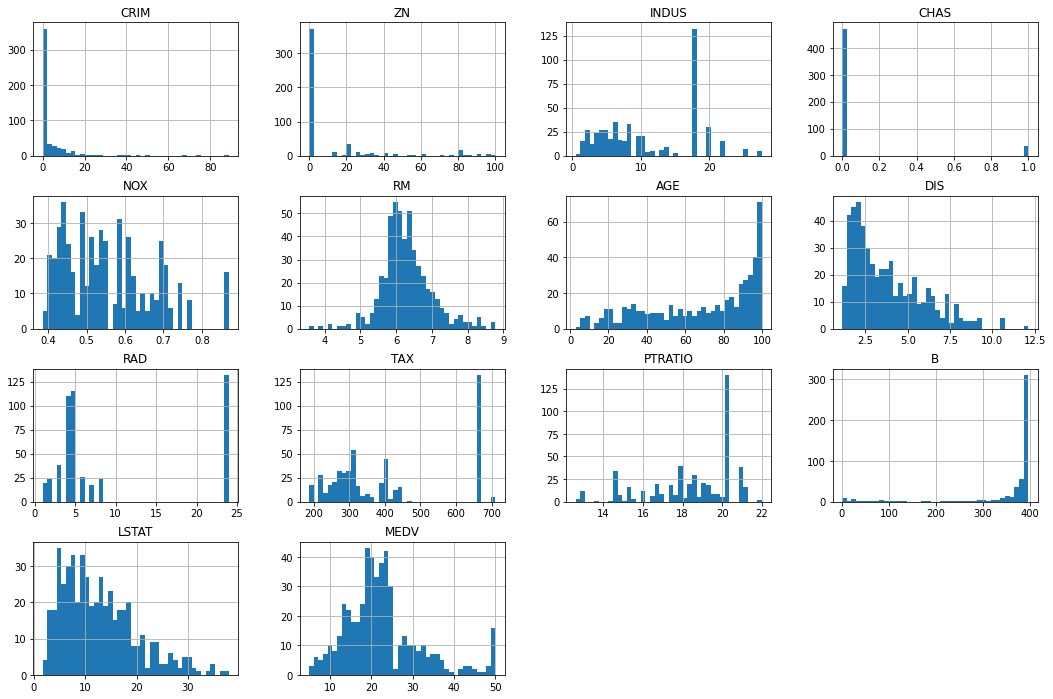

In [12]:
# Wywołaj metodę hist() na obiekcie boston_df 
# Poeksperymentuj z parametrami -- dobrym rozwiązaniem wydają się być wartości (bins = 40, figsize=(18, 12))
# Kod powinien się znajdować powyżej linijki plt.show()
boston_df.hist(bins = 40, figsize=(18, 12))

plt.show()

Ponieważ nasz model będzie modelem regresji liniowej, wartościowe może się okazać przyjrzenie się zależności pomiędzy zmiennymi modelu a zmienną celu. 

Znacie jakiś bardziej elegancki sposób na uzyskanie tego typu wykresów? 

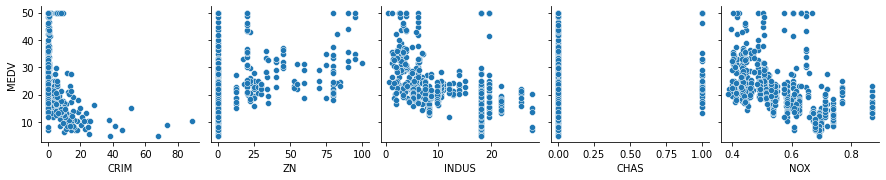

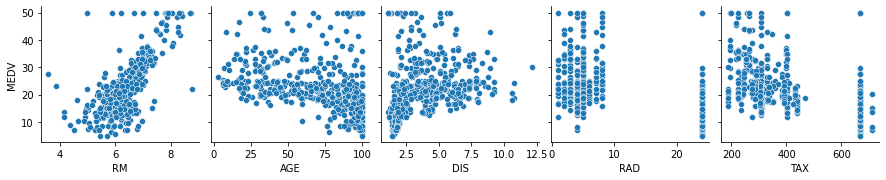

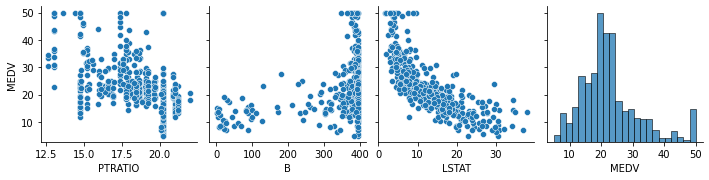

In [13]:
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[:5])
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[5:10])
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[10:])

plt.show()

# 3. Przygotowanie zbioru treningowego oraz testowego

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    boston_df[boston_df.columns.values[:-1]], 
    boston_df[boston_df.columns.values[-1]], 
    test_size=0.33, random_state=42)

# 4. Preprocessing danych

## 4.1. Po co nam preprocessing danych? 

In [15]:
def plot_linear_model(x, y):
    m = LinearRegression()
    m.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
    y_hat = m.predict(x.values.reshape(-1, 1))
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y)
    plt.plot(x, y_hat, c='red')
    plt.show()
    plt.close('all')
    print(f'RMSE: {np.sqrt(mean_squared_error(y, y_hat)):.3f}')

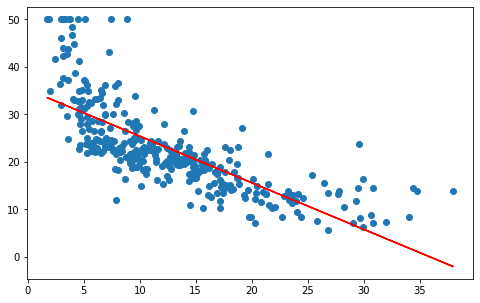

RMSE: 6.222


In [16]:
plot_linear_model(X_train['LSTAT'], y_train)

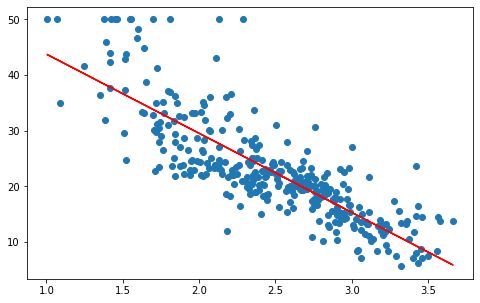

RMSE: 5.307


In [17]:
plot_linear_model(np.log1p(X_train['LSTAT']), y_train)

## 4.2. Właściwy preprocessing danych

Dzięki wywołanej wcześniej metodzie `.info()` wiemy, że w naszym zbiorze danych nie ma braków danych (`506 non-null`). Jedyny preprocessing jaki chcemy wykonać, to transformacja danych.

In [18]:
log_features = ['LSTAT', 'CRIM', 'INDUS', 'NOX']


transformer = ColumnTransformer(
    [
        ('log', FunctionTransformer(np.log1p), log_features)
    ],
    remainder = 'passthrough'
)

# 5. Przygotowanie modelu

## Model liniowy

Wytrenujemy teraz najprostszy model stosowany w problemach regresji: model liniowy. Zostanie on dokładniej omówiony na dalszych zajęciach. Do oceny modelu wykorzystamy miarę **RMSE**. Jest ona zdefiniowana w następujący sposób:

$$ RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^2} $$

Jest to pierwiastek z uśrednionego kwadratu odległości predykcji $\hat{y}$ od wartości prawdziwej $y$. Im niższa wartość, tym lepiej.


In [19]:
pipe_simple = pipe_transformer = Pipeline(
    [
        ('linear-model', LinearRegression())
    ]
)

pipe_transformer = Pipeline(
    [
        ('transformer', transformer),
        ('linear-model', LinearRegression())
    ]
)


In [20]:
pipe_simple.fit(X_train, y_train)
y_test_hat = pipe_simple.predict(X_test)

print(f'RMSE (bez transformacji danych): {np.sqrt(mean_squared_error(y_test, y_test_hat)):.3f}')

RMSE (bez transformacji danych): 4.552


In [21]:
pipe_transformer.fit(X_train, y_train)
y_test_hat = pipe_transformer.predict(X_test)

print(f'RMSE (z transformacją danych): {np.sqrt(mean_squared_error(y_test, y_test_hat)):.3f}')
#alternatywny sposób wywołania funkcji do liczenia RMSE
print(f'RMSE (z transformacją danych): {mean_squared_error(y_test, y_test_hat, squared=False):.3f}')

RMSE (z transformacją danych): 4.193
RMSE (z transformacją danych): 4.193


Możemy zaobserwować, że transformując część zmiennych udało nam się osiągnąć niższą wartość RMSE. 

## Baseline

Skąd wiemy że nasz model radzi sobie dobrze? Standardową strategią w takiej sytuacji jest wybór baselinu, czyli bardzo prostej metody, którą chcemy "przebić". W naszym przypadku, jako baseline przyjmiemy stałą która minimalizuje RMSE.  

Zadanie: Jaka stała minimalizuje RMSE?

W ramach poniżej analizy nie uwzględniono pierwiastka, bo nie zmienia on monotoniczności funkcji którą minimalizujemy.

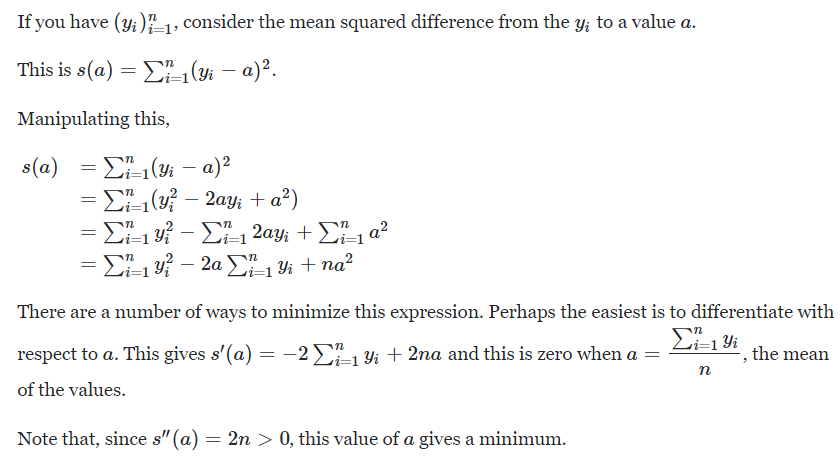

source: https://math.stackexchange.com/questions/2554243/understanding-the-mean-minimizes-the-mean-squared-error

In [ ]:
##TODO: obliczenie baselinu dla zbioru i porównanie go z modelem

## chcemy niezależnie od features zawsze przewidywać taką samą cenę domu, pytanie jaka ta wartość ma być aby błąd był jak najmniejszy
# ze statystyki wiadomo, że powinna być to średnia z y w zbiorze treningowym - miara rozproszenia punktów wokół niej jest najmniejsza

y_base=np.ones(len(y_test))*np.mean(y_train)

print(f'RMSE baseline: {mean_squared_error(y_test, y_base, squared=False):.3f}')

RMSE baseline: 8.800


In [22]:
# w ramach eksperymentów można posprawdzać jakie będzie RMSE dla innych stałych

y_base=np.ones(len(y_test))*1000

print(f'RMSE baseline: {mean_squared_error(y_test, y_base, squared=False):.3f}')

y_base=np.ones(len(y_test))*0.1

print(f'RMSE baseline: {mean_squared_error(y_test, y_base, squared=False):.3f}')


RMSE baseline: 978.395
RMSE baseline: 23.234
